In [30]:
# from craft_text_detector import Craft
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import pytesseract
import scipy.cluster.hierarchy as hcluster

from alice.config import PROCESSING_INPUT_DIR
from alice.predict import predict_masks
from alice.visualise import visualise_mask
from alice.utils import *
from collections import OrderedDict
from itertools import zip_longest

In [20]:
# import craft functions
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)

class Craft():

    def __init__(self, cuda=False):
        
        self.cuda = cuda
        # load models
        self.refine_net = load_refinenet_model(cuda=self.cuda)
        self.craft_net = load_craftnet_model(cuda=self.cuda)

    def detect(self, image):
        h, w = image.shape[:2]  
        # CRAFT internally scales to % 32 - so easier if we scale first
        # rather than trying to align image and heatmap
        h, w = self._calculate_32x_height_width(h, w)
        resized_image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        # Set long size to max dim, otherwise CRAFT will scale
        long_size = max([h, w])

        prediction = get_prediction(
            image=resized_image,
            craft_net=self.craft_net,
            refine_net=self.refine_net,
            text_threshold=0.7,
            link_threshold=0.4,
            low_text=0.4,
            cuda=self.cuda,
            long_size=long_size
        )

        heatmap = prediction["heatmaps"]['text_score_heatmap']
        # Heatmap will always be 2x smaller
        resized_heatmap = cv2.resize(heatmap, (resized_image.shape[1], resized_image.shape[0]), interpolation=cv2.INTER_LINEAR)
        assert resized_heatmap.shape == resized_image.shape        
        prediction['image'] = resized_image
        prediction['resized_heatmap'] = resized_heatmap        
        return prediction

    @staticmethod
    def _scale_32x_dimension(d: int):
        # image height and width should be multiple of 32
        return round(d + (32 - (d % 32)))

    def _calculate_32x_height_width(self, h: int, w: int):
        shortest, longest = sorted([h, w])
        new_longest = self._scale_32x_dimension(longest)
        r = new_longest / longest
        new_shortest = self._scale_32x_dimension(r * shortest)
        return (new_longest, new_shortest) if h > w else (new_shortest, new_longest)   

In [21]:
craft = Craft(cuda=False)

In [22]:
image1 = cv2.imread("norm-image1.jpg")
image2 = cv2.imread("norm-image2.jpg")

print(image1.shape)
print(image2.shape)

(210, 462, 3)
(210, 462, 3)


In [23]:
     

prediction1 = craft.detect(image1)
prediction2 = craft.detect(image2)


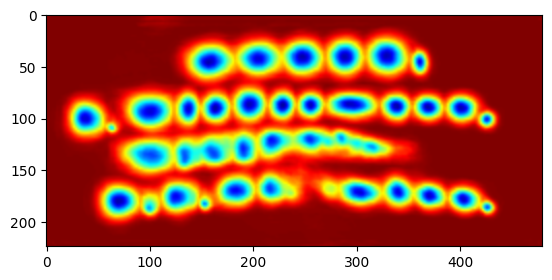

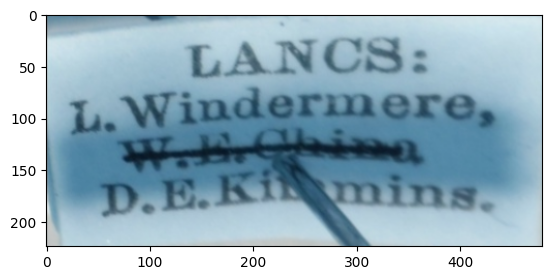

(<matplotlib.image.AxesImage at 0x1586c0ac0>, None)

In [24]:
plt.imshow(prediction2['resized_heatmap']), plt.show()
plt.imshow(prediction2['image']), plt.show()



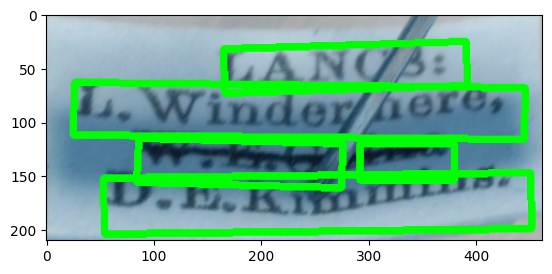

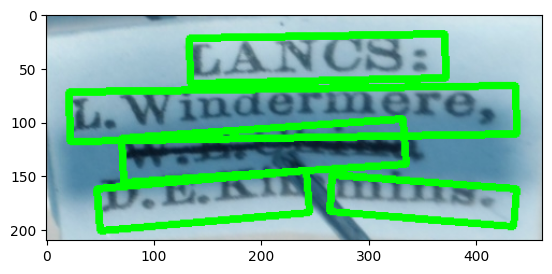

(<matplotlib.image.AxesImage at 0x1588651b0>, None)

In [25]:

img = image1.copy()

for box in prediction1['boxes']:
    points = box.astype(int).reshape((-1, 1, 2))
    cv2.polylines(img, [points], True, (0,255,0), 5) 

plt.imshow(img), plt.show()

img = image2.copy()

for box in prediction2['boxes']:
    points = box.astype(int).reshape((-1, 1, 2))
    cv2.polylines(img, [points], True, (0,255,0), 5) 

plt.imshow(img), plt.show()

# img = image1.copy()

# for box in prediction1['boxes']:
#     points = box.astype(int).reshape((-1, 1, 2))
#     # (x1, y1), (x2, y2), (x3, y3), (x4, y4) = box.astype(int).T

#     output_width = 200
#     output_height = 300
    
#     # Define the destination points for the output rectangle
#     output_points = np.array([[0, 0], [output_width, 0], [output_width, output_height], [0, output_height]], dtype=np.float32)

#     M = cv2.getPerspectiveTransform(points, output_points)

#     # Apply the perspective transformation to the image
#     warped_image = cv2.warpPerspective(img, M, (20, 70))

#     cv2.polylines(img, [points], True, (0,255,0), 5) 
#     break

# plt.imshow(warped_image), plt.show()

In [51]:
# UTILS

from random import randrange

def minmax(arr: np.array):
    return np.min(arr), np.max(arr)
    
def is_range_intersect(range1, range2):
    # FIXME: Is there a upper/lower bounds for np? If not minmax function
    return  pd.Interval(*minmax(range1), closed='both').overlaps(pd.Interval(*minmax(range1), closed='both')) 

def random_colour():
    return (randrange(255), randrange(255), randrange(255))

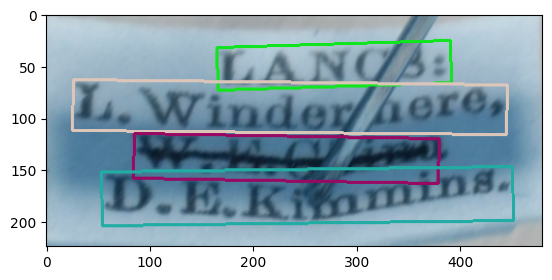

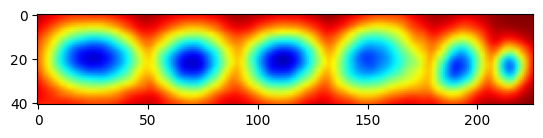

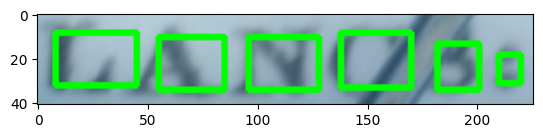

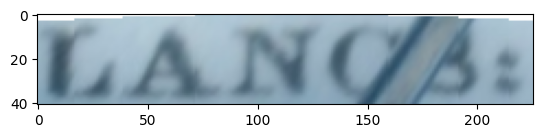

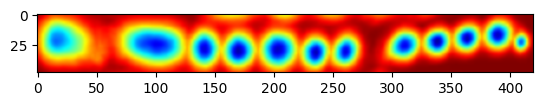

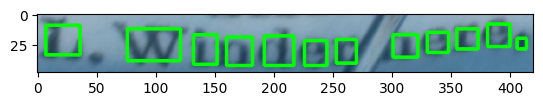

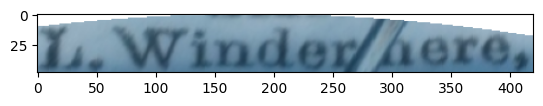

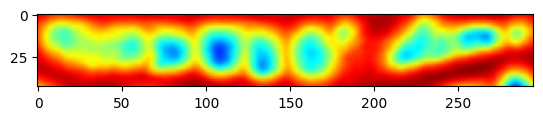

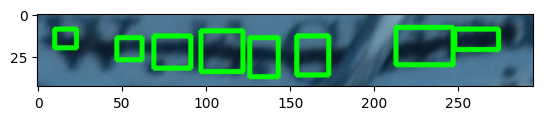

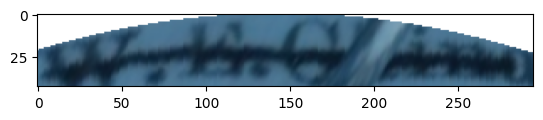

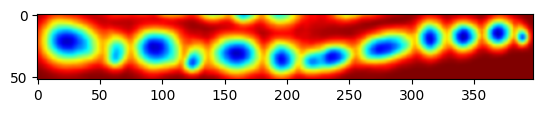

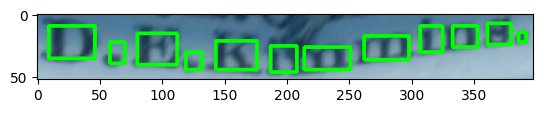

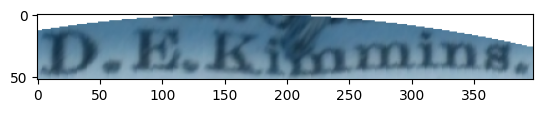

In [146]:
# def extract_text_area(poly, image):
#     # Four corners
#     a,b,c,d = poly.astype(int)
#     # Boxes are quadrilaterals, so we can get width/height from edge lengths
#     width = max([
#         abs(b[0] - a[0]), 
#         abs(c[0] - d[0])
#     ])
#     height = max([
#         abs(a[1] - d[1]), 
#         abs(b[1] - c[1])
#     ])  
#     dst_pts = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)
#     M = cv2.getPerspectiveTransform(box, dst_pts)
#     return cv2.warpPerspective(image, M, (width, height))    

img = image1.copy()

from numpy.polynomial import polynomial as P
from imutils.perspective import order_points
class TextBoundingBox():
    def __init__(self, box, image, heatmap):

        #  Order points from top left clockwise
        self.vertices = order_points(box)
        # Four corners
        a,b,c,d = self.vertices.astype(int)

        # Boxes are quadrilaterals, so we get width/height from edge lengths
        self.width = max([
            abs(b[0] - a[0]), 
            abs(c[0] - d[0])
        ])
        self.height = max([
            abs(a[1] - d[1]), 
            abs(b[1] - c[1])
        ])

        # Transform perspective so we're looking at the line of text straight on
        M = self._get_transformation_matrix()

        self.image = self.warp_perspective(image, M)
        self.heatmap = self.warp_perspective(heatmap, M)

    def _get_transformation_matrix(self):
        dst_pts = np.array([[0, 0], [self.width, 0], [self.width, self.height], [0, self.height]], dtype=np.float32)  
        return cv2.getPerspectiveTransform(self.vertices, dst_pts)         

    def warp_perspective(self, image, M):
        return cv2.warpPerspective(image, M, (self.width, self.height))

    def heatmap_rectangles(self):
        """
        Draw rectangles around points of heatmap density (representing letters)   
        """
    
        heatmap = np.array(cv2.cvtColor(self.heatmap, cv2.COLOR_BGR2GRAY))
    
        # Define the threshold value - values above this will be hotspots to draw boxes around
        threshold = 200    
        # Create a binary mask
        binary_mask = heatmap > threshold    
        # Find contours in the binary mask
        contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
        rects = []        

        # Filter out smaller contours
        min_area = 5
        contours = [contour for contour in contours if cv2.contourArea(contour) >= min_area]
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Remove any boxes along the top/bottom edges
            if y == 0 or (y + h) >= self.height: continue
            
            rects.append([(x, y), (x + w, y + h)])            
        return np.array(rects)        

    def get_line_best_fit(self):
        # Fit a polynomial of degree 2 (quadratic)
        degree = 2    
        rects = self.heatmap_rectangles()
        baseline_centroids = np.array([
            (np.mean(rect[:, 0], dtype=np.int32), max(rect[:, 1])) for rect in rects
        ])   
        x, y = baseline_centroids.T
        coefficients = np.polyfit(x, y, degree) 
        # return P.Polynomial(coefficients)
        return np.poly1d(coefficients)

    def visualise(self):
        image = self.image.copy()
        poly = self.get_line_best_fit()
        xs = np.linspace(0, region.width -1, region.width)
        y_hat = poly(xs)
        for x, y in zip(xs.astype(int),y_hat.astype(int)):
            image[y, x] = [255, 0, 0]            
        
        return image

    def warp(self):
        poly = self.get_line_best_fit()
        x = np.linspace(0, region.width -1, region.width)        
        y_hat = poly(x)        
        # Offset is the predicted y values minus the maximum  
        y_offsets = max(y_hat) - y_hat
        warped = self.image.copy()
        channels = warped.shape[2]
        # Roll down pixels by the offset from the line of best fit
        for i, y_offset in enumerate(y_offsets):
            y = round(y_offset)
            for c in range(channels):
                warped[:, i, c] = np.roll(warped[:, i, c], y)
            warped[:y, i, :] = 255
        return warped

          
# TOMORROW: Ignore this, just have it as a cell.
class TextRegions():

    # craft = Craft()

    # def __init__(image):
    #     # prediction = self.craft.detect(image)
    #     pass

    def __init__(self, prediction):
        self.prediction = prediction
        self.boxes = self._get_text_line_bounding_boxes()    
        
    def _get_text_line_bounding_boxes(self):
        boxes = self._merge_boxes_into_lines(self.prediction['boxes'])
        return [TextBoundingBox(box, self.prediction['image'].copy(), self.prediction['resized_heatmap'].copy()) for box in boxes]

    def _merge_boxes_into_lines(self, boxes):
        """
        Get lines of text boxes, merging boxes if they are single lines of text
        """
        sorted_boxes = sorted(boxes, key=lambda box: np.min(box[:,1]))
        # Create list with the first box
        groups = [[sorted_boxes[0]]]
        
        for box in sorted_boxes[1:]:
            prev = groups[-1][-1]
            # Does the poly fit on the same line as the previous one?
            # And has intersection on the y axis
            if np.min(box[:, 0]) > np.max(prev[:, 0]) and is_range_intersect(box[:, 1], prev[:, 1]):
                groups[-1].append(box)
            else:            
                groups.append([box]) 

        return [self._merge_group(group) for group in groups]    

    @staticmethod
    def _merge_group(group):
        # If we have more than one box in the group, merge all vertices and find min area rect
        if len(group) > 1:
            combined_vertices = np.concatenate(group)
            # Find the convex hull of the combined vertices
            convex_hull = cv2.convexHull(combined_vertices)        
            # Fit a rotated rectangle around the convex hull
            rect = cv2.minAreaRect(convex_hull)
            return cv2.boxPoints(rect)
        else:
            return group[0]   

    def visualise(self):  
        image = self.prediction['image'].copy()
        for bbox in self.boxes:
            cv2.polylines(image, [bbox.vertices.astype(int)], True, random_colour(), 2) 
        return image
        

    def __iter__(self):
        yield from self.boxes






regions = TextRegions(prediction1)


vis = regions.visualise()

plt.imshow(vis, 'gray')
plt.show()

for region in regions:
    vis = region.image.copy()
    rects = region.heatmap_rectangles()

    for rect in rects:
        pt1, pt2 = rect
        cv2.rectangle(vis, pt1, pt2, (0, 255, 0), 2)

    # print(r)
    
    plt.imshow(region.heatmap, 'gray')
    plt.show()
    
    plt.imshow(vis, 'gray')
    plt.show()


    plt.imshow(region.warp(), 'gray')
    plt.show()    

# regions = TextLine(prediction2)
# for region in regions:
#     plt.imshow(region.image), plt.show()
#     plt.imshow(region.heatmap), plt.show()
#     # print(region)




# def extract_text_areas(prediction):
#     plt.imshow(prediction2['resized_heatmap']), plt.show()
# plt.imshow(prediction2['image']), plt.show()
#     image = prediction['image']
#     for 
    

# for box in prediction1['boxes']:
#     text_box1 = extract_text_box(box, img)
#     # break

    

# img = image2.copy()
# for box in prediction2['boxes']:
#     text_box2 = extract_text_box(box, img)
#     # break    


# plt.imshow(text_box1), plt.show()
# plt.imshow(text_box2), plt.show()


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


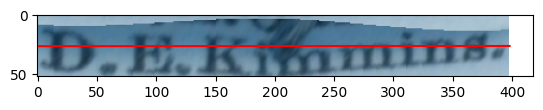

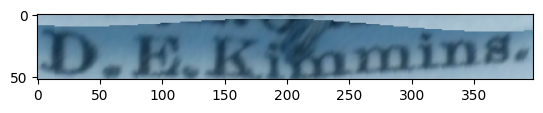

In [371]:
from pygam import GAM, LinearGAM, s, f, te
import csv
import pandas as pd

def dewarp_text(image, n_splines = 5):
    # Grayscale it, Otsu's threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    # Dilation & Erosion to fill holes inside the letters
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)  

    # scatter = []

    # # Write in csv file
    # for x in range(thresh.shape[0]):
    #     for y in range(thresh.shape[1]):
    #         # Search for black pixels
    #         if (thresh[x][y] <= 128):
    #             scatter.append({
    #                 'Y': y,
    #                 'X': thresh.shape[0] - x
    #             })

    # df = pd.DataFrame(scatter)


    # Open csv file
    f = open('./scatterplot_records.csv', 'w')
    
    # Create the csv writer
    writer = csv.writer(f)
    writer.writerow(['X', 'Y'])
    
    # Write in csv file
    for x in range(thresh.shape[0]):
        for y in range(thresh.shape[1]):
          # Search for black pixels
          if (thresh[x][y] <= 128):
            #writer.writerow([y, x])                        # reverse/mirrored scatter-plot image
            writer.writerow([y, thresh.shape[0] - x])       # normal scatter-plot image
    
    # Close csv file
    f.close()
    
    # Read CSV file and extract info
    df = pd.read_csv('./scatterplot_records.csv', sep = ",")
    
    # Delete csv file
    # os.remove('./scatterplot_records.csv')
    
    # Build GAM & define its parameters
    predictors = ['X']
    outcome = ['Y']
    X = df[predictors].values
    y = df[outcome]
    gam = LinearGAM(n_splines = n_splines)
    gam.gridsearch(X, y)
    
    # Create the offset necessary to un-curve the text
    y_hat = gam.predict(np.linspace(0, thresh.shape[1], num = thresh.shape[1]))
  
    # # Plot the image with text curve overlay
    plt.imshow(image)
    plt.plot(np.linspace(0, thresh.shape[1], num=thresh.shape[1]), (thresh.shape[0] - y_hat), color='red')
    plt.show()

    # Roll each column to align the text
    for i in range(image.shape[1]):
        image[:, i, 0] = np.roll(image[:, i, 0], round(y_hat[i] - thresh.shape[0]/2))
        image[:, i, 1] = np.roll(image[:, i, 1], round(y_hat[i] - thresh.shape[0]/2))
        image[:, i, 2] = np.roll(image[:, i, 2], round(y_hat[i] - thresh.shape[0]/2))

    return image

de = dewarp_text(text_box1)        
plt.imshow(de)
plt.show()

# print(de)


In [361]:
!pip install pygam

  Using cached pygam-0.9.0-py3-none-any.whl (522 kB)
  Using cached progressbar2-4.2.0-py2.py3-none-any.whl (27 kB)
  Using cached python_utils-3.7.0-py2.py3-none-any.whl (26 kB)
You should consider upgrading via the '/Users/ben/Projects/NaturalHistoryMuseum/ALICE/CRAFT-pytorch/.venv/bin/python -m pip install --upgrade pip' command.


In [6]:
heatmap1 = np.array(cv2.cvtColor(prediction_result1["heatmaps"]['text_score_heatmap'], cv2.COLOR_BGR2GRAY))
heatmap2 = np.array(cv2.cvtColor(prediction_result2["heatmaps"]['text_score_heatmap'], cv2.COLOR_BGR2GRAY))

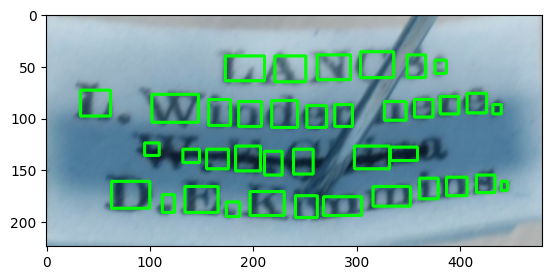

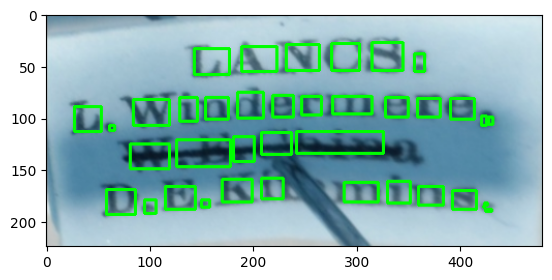

In [195]:
def heatmap_rectangles(heatmap):

    heatmap = np.array(cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY))

    # Define the threshold value - values above this will be hotspots to draw boxes around
    threshold = 200    
    # Create a binary mask
    binary_mask = heatmap > threshold    
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rects = []
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        rects.append([(x, y), (x + w, y + h)])
        
    return np.array(rects)



heatmap1 = np.array(cv2.cvtColor(resize_heatmap(prediction_result1["heatmaps"]['text_score_heatmap'], image1), cv2.COLOR_BGR2GRAY))
heatmap2 = np.array(cv2.cvtColor(resize_heatmap(prediction_result2["heatmaps"]['text_score_heatmap'], image2), cv2.COLOR_BGR2GRAY))

rects1 = heatmap_rectangles(prediction1['resized_heatmap'])    
rects2 = heatmap_rectangles(prediction2['resized_heatmap'])   

vis = prediction1['image'].copy()

for rect in rects1:
    pt1, pt2 = rect
    cv2.rectangle(vis, pt1, pt2, (0, 255, 0), 2)

plt.imshow(vis, 'gray')
plt.show()

vis = prediction2['image'].copy()

for rect in rects2:
    pt1, pt2 = rect
    cv2.rectangle(vis, pt1, pt2, (0, 255, 0), 2)

plt.imshow(vis, 'gray')
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

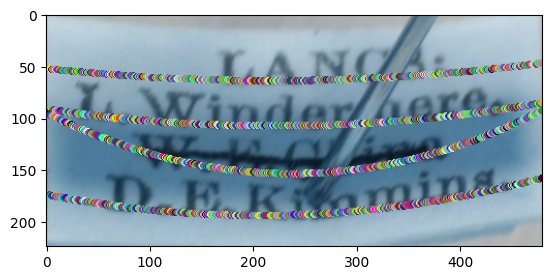

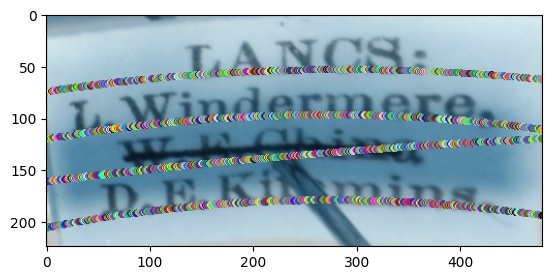

In [564]:
# Remove small boxes. Group into lines of text
# Draw line of best fit
# Put dots along that line of best fits at every 50 pixels

def cluster_char_rectangles_horizontal_axis(rects):
    # Letter baselines will have more homogeneity, so cluster using centroid of the baseline
    baselines = np.array([max(y) for y in rects[:,:, 1]])
    
    cluster_labels = hcluster.fclusterdata(baselines.reshape(-1,1), t=4, criterion="maxclust")
    
    cluster_rectangles = {}
    for i, rect in enumerate(rects):
        cluster_index = cluster_labels[i]
        cluster_rectangles.setdefault(cluster_index, []).append(rect)

    clusters_list = [np.array(l) for l in cluster_rectangles.values()]
    sorted_clusters = sorted(clusters_list, key=lambda l: np.max(l[:,:, 1]))    
    return sorted_clusters

def get_line_best_fit(rects, x_range):

    # Fit a polynomial of degree 2 (quadratic)
    degree = 2    
    clusters = cluster_char_rectangles_horizontal_axis(rects)
    lines = {}
    
    for i, cluster in enumerate(clusters):
        baseline_centroids = np.array([
            (np.mean(rect[:, 0], dtype=np.int32), max(rect[:, 1])) for rect in cluster
        ])        
        x, y = baseline_centroids.T
        coefficients = np.polyfit(x, y, degree)        
        y_pred = np.polyval(coefficients, x_range).astype(np.int32) 
        lines[i] = [(x, y) for x, y in zip(x_range, y_pred)]

    return lines

    np.poly1d(coefficients)

image1 = prediction1['image']
image2 = prediction2['image']

w = image1.shape[1] 
x = list(range(0, w, 1))   

y1 = get_line_best_fit(rects1, x)
y2 = get_line_best_fit(rects2, x)

clusters = cluster_char_rectangles_horizontal_axis(rects1)


vis1 = image1.copy()
vis2 = image2.copy()

src_pts = []
dst_pts = []
for i in y1.keys():
    assert len(y1[i]) == len(y2[i]) 

    # if i in [1, 2]: continue

    for src_pt, dst_pt in zip(y1[i], y2[i]):
        random_color = tuple(np.random.randint(0, 256, size=3).astype(np.int32))

        x = tuple([int(i) for i in random_color])

        cv2.circle(vis1, src_pt, 2, x, thickness=2)
        cv2.circle(vis2, dst_pt, 2, x, thickness=2)
        src_pts.append(src_pt)
        dst_pts.append(dst_pt)

src_pts = np.float32(src_pts)
dst_pts = np.float32(dst_pts)

# clusters = cluster_char_rectangles_horizontal_axis(rects1)
# lines = {}

# for i, cluster in clusters.items():
#     baseline_centroids = np.array([
#         (np.mean(rect[:, 0], dtype=np.int32), max(rect[:, 1])) for rect in cluster
#     ])  

#     for c in baseline_centroids:
#         cv2.circle(vis1, c, 2, (250, 250, 0), thickness=2)
        
#     break

# for rect in rects1:
#     pt1, pt2 = rect
#     cv2.rectangle(vis1, pt1, pt2, (0, 255, 0), 1)
    

plt.imshow(vis1)
plt.show()  

plt.imshow(vis2)
plt.show()  

# for i, cluster in cluster_rectangles.items():
#     baseline_centroids = np.array([
#         (np.mean(rect[:, 0], dtype=np.int32), max(rect[:, 1])) for rect in cluster
#     ])

#     x, y = baseline_centroids.T

#     print(len(x))
#     print(len(y))

#     # Fit a polynomial of degree 2 (quadratic)
#     degree = 2
#     coefficients = np.polyfit(x, y, degree)

#     y_pred = np.polyval(coefficients, x_intervals)

#     print(y_pred)

#     # print(baseline_centroids[:,0])

#     break
    

# plt.scatter(x, y, label='Data Points')
# plt.plot(x_intervals, y_pred, color='red', label='Curve of Best Fit (Degree 2)')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Curved Line of Best Fit')
# plt.legend()
# plt.show()
    
# clustered = np.array(list(zip(cluster_labels, rects)))

# print(rects)
# print(type(rects2))

# for cluster_label in set(cluster_labels):
#     print(cluster_label)


# # SNumber of clusters - TODO use centence boxes?
# num_clusters = 4

# # # Perform K-Means clustering
# kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
# cluster_labels = kmeans.fit_predict(baselines.reshape(-1, 1))

# clustered = list(zip(cluster_labels, rects))

# vis = np.zeros(binary_mask.shape + (3,), dtype=np.uint8)

# for cluster_index, rect in clustered:
#     r = 50 * int(cluster_index) + 1
#     pt1, pt2 = rect
#     cv2.rectangle(vis, pt1, pt2, (r, 50, 50), 2)

# # print(list(clustered))

# # clustered = [[] for _ in range(len(cluster_labels))]
# # for i, rect in enumerate(rects2):
# #     cluster_index = cluster_labels[i]
# #     clustered[cluster_index].append(rect)
    
# # vis = np.zeros(binary_mask.shape + (3,), dtype=np.uint8)

# # for rect in rects2:
# #     pt1, pt2 = rect
# #     cv2.rectangle(vis, pt1, pt2, (0, 255, 0), 2)

# # for cluster_index, cluster in enumerate(clustered):
# #     # color = plt.cm.viridis(cluster_index / num_clusters)  # Different color for each cluster
# #     r = 50 * cluster_index


        


        


# # cluster_rectangles = [[] for _ in range(num_clusters)]
# # for i, rect in enumerate(rects):
# #     cluster_index = cluster_labels[i]
# #     cluster_rectangles[cluster_index].append(rect)



# # for cluster_index, cluster in enumerate(cluster_rectangles):
# #     color = plt.cm.viridis(cluster_index / num_clusters)  # Different color for each cluster
# #     r = 50 * cluster_index
# #     for rect in cluster:
# #         pt1, pt2 = rect
# #         cv2.rectangle(image_with_boxes2, pt1, pt2, (r, 50, 50), 2)
        

# # plt.imshow(image_with_boxes2)
# # plt.show()        


[[ 1.01828366e+00  2.73316872e-02 -3.54370195e+00]
 [-6.68990607e-03  9.94803524e-01  6.97037986e+00]
 [ 1.10892788e-05  1.15145151e-04  1.00000000e+00]]


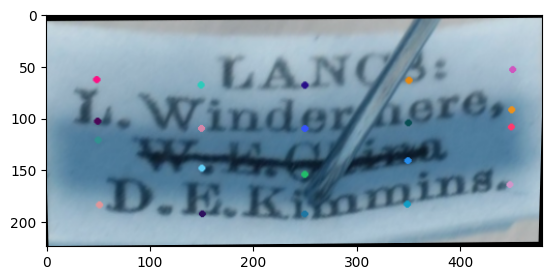

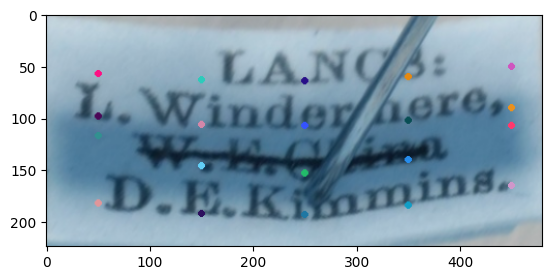

In [259]:
image1 = prediction1['image'].copy()
image2 = prediction2['image'].copy()

h, w = vis1.shape[:2]

# Define the source and destination points


# Calculate the homography matrix
M, mask = cv2.findHomography(src_pts, dst_pts,  cv2.RANSAC, 100)

# print(src_pts)
# print(dst_pts)
print(M)

# # Apply the transformation using warpPerspective
transformed_img = cv2.warpPerspective(vis1, M, (w, h))

# # plt.figure(figsize = (50,20))
plt.imshow(transformed_img)
plt.show()

plt.imshow(vis1)
plt.show()

In [ ]:
existing_array = np.array([[1, 2], [3, 4], [5, 6]])
new_column = [7, 8, 9]

new_array = np.column_stack((existing_array, new_column))
# print(new_array)

rects

In [ ]:
!pip install pandas

In [ ]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.scatter(ys[:, 1], ys[:, 0])


In [ ]:
import scipy.cluster.hierarchy as hcluster

boxes_y1 = []

boxes = rects

for b in rects:
    boxes_y1.append(b[:,1][1])
    
boxes_y1 = np.array(boxes_y1)

thresh = 15
clusters = hcluster.fclusterdata(boxes_y1.reshape(-1,1), t=4, criterion="maxclust")
print(len(np.unique(clusters)))

cols2 = {}
cols2[1] = 'r'
cols2[2] = 'g'
cols2[3] = 'b'
cols2[4] = 'k'
cols2[5] = 'y'

 

fig,ax = plt.subplots(figsize=(7,3))

 

for i,b in enumerate(boxes):
    x = [b[0][0],b[0][0],b[1][0],b[1][0],b[0][0]]
    y = [b[0][1],b[1][1],b[1][1],b[0][1],b[0][1]]
    col = cols2[clusters[i]]
    ax.plot(x,y,color=col)

ax.set_ylim([300,0])
ax.set_xlim([0,630])


In [ ]:
boxes_y1

In [260]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac

In [261]:
model = AffineTransform()
model.estimate(src_pts, dst_pts)

True

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data

In [263]:
src = src_pts.copy()
dst = dst_pts.copy()


tform = PiecewiseAffineTransform()
tform.estimate(src, dst)


True

In [268]:
h, w = vis1.shape[:2]
out = warp(vis2, tform, output_shape=(h,w))

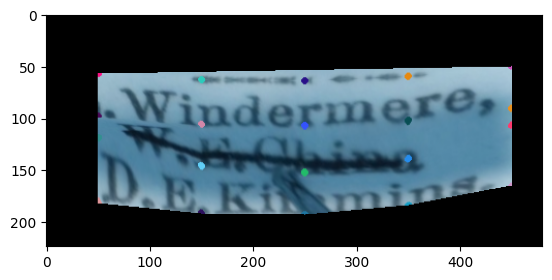

In [269]:
plt.imshow(out)
plt.show()

In [270]:
import numpy as np
import cv2
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

In [271]:
src_x, src_y = src_pts[:, 0], src_pts[:, 1]
dst_x, dst_y = dst_pts[:, 0], dst_pts[:, 1]

In [276]:
# Create radial basis function (RBF) interpolators
rbf_x = Rbf(src_x, src_y, dst_x)
rbf_y = Rbf(src_x, src_y, dst_y)

# Create grid of coordinates for the new warped image
new_x, new_y = np.meshgrid(np.arange(vis1.shape[1]), np.arange(vis2.shape[0]))



In [277]:
# Apply the TPS transformation to get new x and y coordinates
warped_x = rbf_x(new_x, new_y)
warped_y = rbf_y(new_x, new_y)

# Create the warped image using interpolation
warped_image = cv2.remap(vis1, warped_x.astype(np.float32), warped_y.astype(np.float32), interpolation=cv2.INTER_LINEAR)


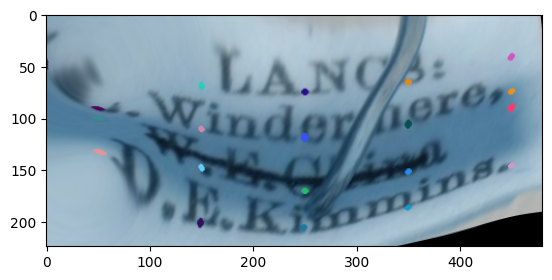

In [278]:
plt.imshow(warped_image)
plt.show()

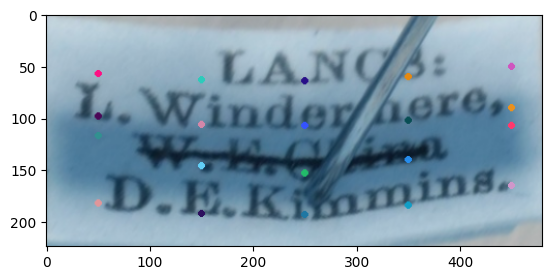

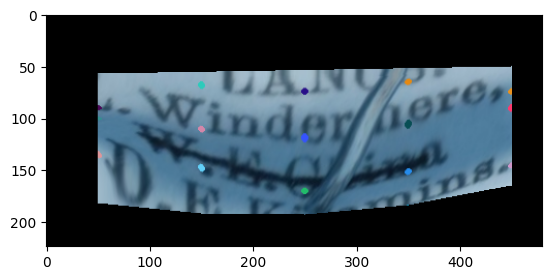

In [288]:
import numpy as np
import cv2
from scipy.interpolate import griddata

# Load the image
image = vis1.copy()

# Define a subset of source points
subset_src_points = src_pts

# Define the destination points
destination_points = dst_pts

# Separate x and y coordinates of source and destination points
subset_src_x, subset_src_y = subset_src_points[:, 0], subset_src_points[:, 1]
dest_x, dest_y = destination_points[:, 0], destination_points[:, 1]

# Create a grid of coordinates for the new warped image
new_x, new_y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

# Perform the TPS transformation using scipy.interpolate.griddata
warped_x = griddata((subset_src_x, subset_src_y), dest_x, (new_x, new_y), method='cubic')
warped_y = griddata((subset_src_x, subset_src_y), dest_y, (new_x, new_y), method='cubic')

# Create the warped image using cv2.remap
warped_image = cv2.remap(image, warped_x.astype(np.float32), warped_y.astype(np.float32), interpolation=cv2.INTER_LINEAR)

plt.imshow(image)
plt.show()

plt.imshow(warped_image)
plt.show()


In [375]:
y1

# clusters = cluster_char_rectangles_horizontal_axis(rects1)

{0: [(50, 57), (150, 63), (250, 64), (350, 60), (450, 50)],
 1: [(50, 98), (150, 106), (250, 107), (350, 102), (450, 90)],
 2: [(50, 117), (150, 146), (250, 153), (350, 140), (450, 107)],
 3: [(50, 182), (150, 192), (250, 193), (350, 184), (450, 165)]}

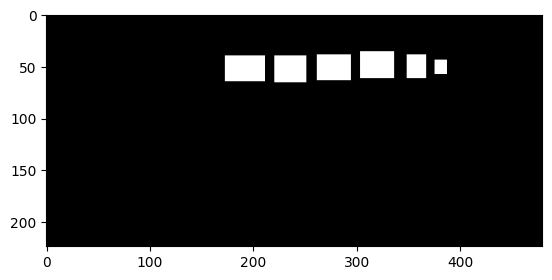

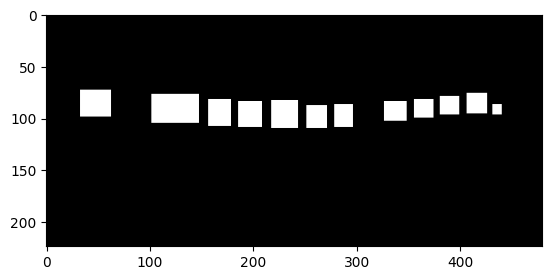

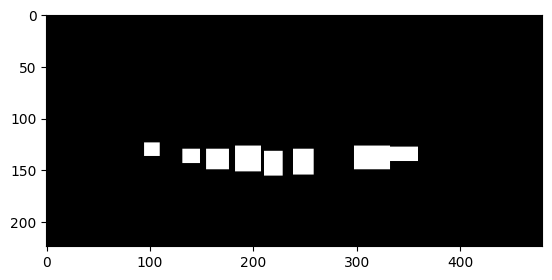

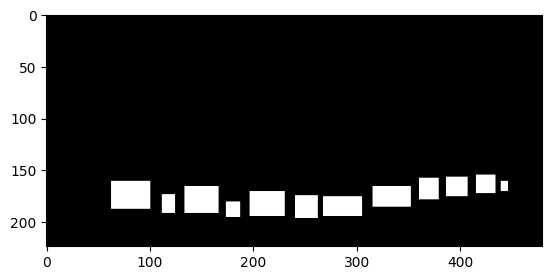

{0: [0], 1: [1, 2], 2: [2, 3], 3: [3, 4]}


In [603]:
clusters

pred = prediction2
vis = pred['image'].copy() 

h, w = vis.shape[:2]

def get_poly_mask(poly, width, height):
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask,[poly.astype(int)], 255)
    return mask

def get_rectangles_mask(rects, width, height):    
    mask = np.zeros((height, width), dtype=np.uint8)
    for pt1, pt2 in rects:
        cv2.rectangle(mask, pt1, pt2, 255, -1)
    return mask
    
    

    
box_masks = [get_poly_mask(box, w, h) for box in pred['boxes']]

intersecting_boxes = {}
for cluster_idx, cluster in enumerate(clusters):
    cluster_mask = get_rectangles_mask(cluster, w, h)
    plt.imshow(cluster_mask, 'gray')
    plt.show()        
    for box_mask_idx, box_mask in enumerate(box_masks):
        intersection = cluster_mask & box_mask
        if np.count_nonzero(intersection):
            intersecting_boxes.setdefault(cluster_idx, []).append(box_mask_idx)

# TODO: Filter these based on if they overlap horizontally etc.,

print(intersecting_boxes)
                  
intersecting_boxes[1] = [1]   
intersecting_boxes[2] = [2]   







In [28]:
# def horizontally_group_rectangles(rects):
#     """
#     Group rect horizontally, treating their y coords as intervals

#     So if we have two rects in a line (with intersection on the y axis) they will form one group
    
#     """
#     groups = []
#     rects = np.array(rects)
    
#     # Iterate through intervals to form groups
#     for rect in rects:
#         group_found = False
#         interval = pd.Interval(*rect[:, 1], closed='both')    
#         for group in groups:
#             if any(interval.overlaps(pd.Interval(*group_rect[:, 1], closed='both')) for group_rect in group):
#                 group.append(rect)
#                 group_found = True
#                 break
        
#         if not group_found:
#             groups.append([rect])    

#     return groups


polygons = pred['boxes'][0:5]

sorted_polygons = sorted(polygons, key=lambda poly: np.min(poly[:,1]))

# print(sorted_rects)

vis = prediction2['image'].copy()



for i, group in enumerate(groups):
    r = i * 75
    b = i * 50
    for rect in group:

        cv2.polylines(vis, [rect.astype(int)], True, (r,100,b), 5) 

# print(group)
#     pt1, pt2 = rect
#     cv2.rectangle(vis, pt1, pt2, (0, 255, 0), 2)

# plt.imshow(vis, 'gray')
# plt.show()

# print(group)

print(groups)



NameError: name 'pred' is not defined

In [631]:
def is_range_intersect(range1, range2):
    return  pd.Interval(*range1, closed='both').overlaps(pd.Interval(*range2, closed='both')) 

is_range_intersect((1,3), (4,6))

False

[[ 47.483685 148.12593 ]
 [438.17136  143.72017 ]
 [438.7725   197.02492 ]
 [ 48.08481  201.43068 ]]


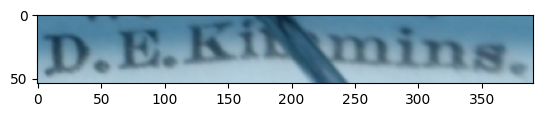

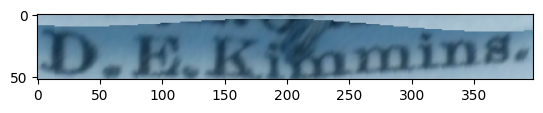

In [467]:
to_combine = intersecting_boxes[3]

combine_boxes = [box for i, box in enumerate(pred['boxes']) if i in to_combine]

combined_vertices = np.concatenate(combine_boxes)

# Find the convex hull of the combined vertices
convex_hull = cv2.convexHull(combined_vertices)

# Fit a rotated rectangle around the convex hull
rect = cv2.minAreaRect(convex_hull)
box = cv2.boxPoints(rect)

def extract_text_box(box, image):
    # Four corners
    a,b,c,d = box.astype(int)
    # Boxes are quadrilaterals, so we can get width/height from edge lengths
    width = max([
        abs(b[0] - a[0]), 
        abs(c[0] - d[0])
    ])
    height = max([
        abs(a[1] - d[1]), 
        abs(b[1] - c[1])
    ])  

    print(box)
    
    dst_pts = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(box, dst_pts)
    return cv2.warpPerspective(image, M, (width, height))  


text_box2 = extract_text_box(box, vis)


# print(box)


plt.imshow(text_box2)
plt.show()  

plt.imshow(text_box1)
plt.show()  

# pt1, pt2, = box
# cv2.rectangle(vis, pt1, pt2, (r, 50, 50), 2)

# #     r = 50 * cluster_index
# #     for rect in cluster:
# #         pt1, pt2 = rect
# #         cv2.rectangle(image_with_boxes2, pt1, pt2, (r, 50, 50), 2)
        




# for box in pred['boxes']:
#     print(box)
#     break

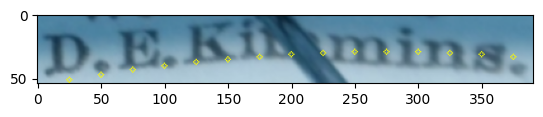

In [555]:
mid_y = 31

dst_pts = []
vis = text_box2.copy()
for pt in y2[3]:
    x, y = pt
    y -= 150
    dst_pts.append([x, 31])    
    cv2.circle(vis, (x, y), 2, (250, 250, 0), thickness=1)

plt.imshow(vis)
plt.show()  

[[ 25. 201.]
 [ 50. 197.]
 [ 75. 193.]
 [100. 190.]
 [125. 187.]
 [150. 185.]
 [175. 183.]
 [200. 181.]
 [225. 180.]
 [250. 179.]
 [275. 179.]
 [300. 179.]
 [325. 180.]
 [350. 181.]
 [375. 183.]
 [400. 185.]
 [425. 187.]
 [450. 190.]
 [475. 193.]
 [ 10.  10.]
 [ 10. 381.]]
[[ 6.06248263e-01 -8.33120276e-03 -2.29670269e+00]
 [ 6.48079132e-03  3.70479202e-02  9.34455015e+00]
 [ 1.40081808e-04 -2.46625804e-03  1.00000000e+00]]


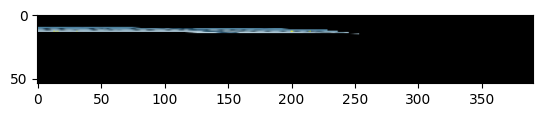

In [558]:
src_points = deepcopy(y2[3])
dst_points = deepcopy(dst_pts)

h, w = vis.shape[:2]

pts = [[10, 10], [10, w - 10]]

src_points.extend(pts)
dst_points.extend(pts)

src_points = np.array(src_points, dtype=np.float32)
dst_points = np.array(dst_points, dtype=np.float32)

print(src_points)

M, mask = cv2.findHomography(src_points, dst_points)

print(M)

warped = cv2.warpPerspective(vis, M, (w, h))  

# # # # cv2.warpPerspective(vis, h, size)
plt.imshow(warped)
plt.show()  

# plt.imshow(vis)
# plt.show()  


In [575]:
def dewarp_text(image, n_splines = 5):
    # Grayscale it, Otsu's threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    # Dilation & Erosion to fill holes inside the letters
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)  

    # scatter = []

    # # Write in csv file
    # for x in range(thresh.shape[0]):
    #     for y in range(thresh.shape[1]):
    #         # Search for black pixels
    #         if (thresh[x][y] <= 128):
    #             scatter.append({
    #                 'Y': y,
    #                 'X': thresh.shape[0] - x
    #             })

    # df = pd.DataFrame(scatter)


    # Open csv file
    f = open('./scatterplot_records.csv', 'w')
    
    # Create the csv writer
    writer = csv.writer(f)
    writer.writerow(['X', 'Y'])
    
    # Write in csv file
    for x in range(thresh.shape[0]):
        for y in range(thresh.shape[1]):
          # Search for black pixels
          if (thresh[x][y] <= 128):
            #writer.writerow([y, x])                        # reverse/mirrored scatter-plot image
            writer.writerow([y, thresh.shape[0] - x])       # normal scatter-plot image
    
    # Close csv file
    f.close()
    
    # Read CSV file and extract info
    df = pd.read_csv('./scatterplot_records.csv', sep = ",")
    
    # Delete csv file
    # os.remove('./scatterplot_records.csv')
    
    # Build GAM & define its parameters
    predictors = ['X']
    outcome = ['Y']
    X = df[predictors].values
    y = df[outcome]

    print(len(X))
    print(h * w)
    
    
    gam = LinearGAM(n_splines = n_splines)
    gam.gridsearch(X, y)
    
    # Create the offset necessary to un-curve the text
    y_hat = gam.predict(np.linspace(0, thresh.shape[1], num = thresh.shape[1]))
  
    # # Plot the image with text curve overlay
    plt.imshow(image)
    plt.plot(np.linspace(0, thresh.shape[1], num=thresh.shape[1]), (thresh.shape[0] - y_hat), color='red')
    plt.show()

    # Roll each column to align the text
    for i in range(image.shape[1]):
        image[:, i, 0] = np.roll(image[:, i, 0], round(y_hat[i] - thresh.shape[0]/2))
        image[:, i, 1] = np.roll(image[:, i, 1], round(y_hat[i] - thresh.shape[0]/2))
        image[:, i, 2] = np.roll(image[:, i, 2], round(y_hat[i] - thresh.shape[0]/2))

    return image

# de = dewarp_text()        
# plt.imshow(de)
# plt.show()

# print(round(y_hat[i] - thresh.shape[0]/2))

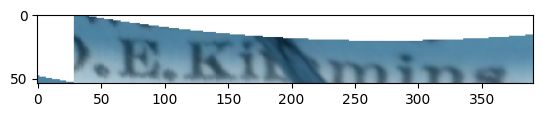

In [601]:
img = text_box2.copy()

h, w, channels = img.shape
# new_image.fill(255)

# y_hat = dict(y2[3])

for i in range(w):
    # new_image[new_y:new_y+height, new_x:new_x+1, :] = image[:, x:x+1, :]

    y = (200 - y_hat[i]) or 0
    # print(y)
    for c in range(channels):
        img[:, i, c] = np.roll(img[:, i, c], y)
        
    img[:y, i, :] = 255
    pass
    

plt.imshow(img)
plt.show()    


In [602]:
# When I cut the box, perform same cut on the heatmap
# Recalculate boxes and line of best fit - using 
# Create a callable polynomial function
# polynomial_function = np.poly1d(coefficients)
# How to turn line of best fit into a function to get top offset?


In [124]:
a = np.array([20, 22, 21, 20])
x = 19
a - x

array([1, 3, 2, 1])

# Calculate the polynomial coefficients
coefficients = np.polyfit(x, y, degree)

# Create a callable polynomial function
polynomial_function = np.poly1d(coefficients)

# Test the polynomial function with a specific x value
x_value = 6
y_value = polynomial_function(x_value)